In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torch.nn.init as init
from torch.autograd import Variable
from dataLoader import loadData
from tensorflow import keras

In [2]:
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip

In [3]:
# !curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [10]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')
    
# # !cd ml-1m/

In [4]:
# import zipfile
# with zipfile.ZipFile('ml-100k.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')
    
# # !cd ml-1m/

In [5]:
seed = 47
np.random.seed(seed)

We will use the following blogpost's independent code to benchmark our experiments https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea

# Independent MF code

In [6]:
names = ['user_id', 'item_id', 'rating']
df = pd.read_csv('./ml-1m/ratings.dat', sep='::', usecols = [0, 1, 2], names=names)
df.head()

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,user_id,item_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [7]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
n_users, n_items

(6040, 3706)

In [8]:
df.item_id.unique().max(), df.item_id.unique().shape, df.item_id.unique().max()

(3952, (3706,), 3952)

In [9]:
n_users = df.user_id.unique().max()
n_items = df.item_id.unique().max()
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
#     print(row)
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [10]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [11]:
get_sparsity(ratings)

4.190220560634904

In [12]:
def train_test_split(ratings):
    np.random.seed(seed)
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [13]:
train_1m, test_1m = train_test_split(ratings)

In [14]:
train_1m

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [15]:
test_1m

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
get_sparsity(train_1m), get_sparsity(test_1m)

(3.93718412338794, 0.25303643724696356)

In [17]:
# movielens-100k dataset
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [18]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [19]:
train_100k, test_100k = train_test_split(ratings)

In [20]:
get_sparsity(train_100k), get_sparsity(test_100k)

(5.710139043178159, 0.5945303210463734)

In [21]:
train_100k.shape, train_1m.shape

((943, 1682), (6040, 3952))

In [25]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        np.random.seed(seed)
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        np.random.seed(seed)
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        np.random.seed(seed)
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        np.random.seed(seed)
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        np.random.seed(seed)
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [26]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [28]:
MF_ALS = ExplicitMF(train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.8411868244782985
Test mse: 10.956557787912471
Iteration: 2
Train mse: 5.731156257503645
Test mse: 8.66466855942882
Iteration: 5
Train mse: 5.41223275733234
Test mse: 8.225124472876551
Iteration: 10
Train mse: 5.394598612851955
Test mse: 8.198143635604692
Iteration: 25
	current iteration: 10
Train mse: 5.3944670279169324
Test mse: 8.195114378325407
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.394455951420811
Test mse: 8.194896519679713
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.394255047026079
Test mse: 8.194688553798981


In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

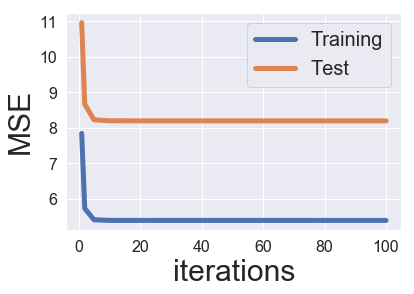

In [30]:
plot_learning_curve(iter_array, MF_ALS)

In [105]:
MF_ALS = ExplicitMF(train_1m, n_factors=20, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test_1m)

Iteration: 1
Train mse: 8.133017313467287
Test mse: 11.385478952329686
Iteration: 2
Train mse: 6.181422331570321
Test mse: 9.510432053967698
Iteration: 5
Train mse: 5.945868319505223
Test mse: 9.181499199125527
Iteration: 10
Train mse: 5.929921005207816
Test mse: 9.163591900058499
Iteration: 25
	current iteration: 10
Train mse: 5.922879579194776
Test mse: 9.155637570112932
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.921741164281515
Test mse: 9.152673442345948
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.921434636456923
Test mse: 9.152593151189302


In [110]:
MF_SGD = ExplicitMF(train_100k, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.142807793060997
Test mse: 1.1796269767247503
Iteration: 2
Train mse: 1.0730325987217215
Test mse: 1.1283621352778417
Iteration: 5
Train mse: 0.9767157588922124
Test mse: 1.0499014864558258
Iteration: 10
Train mse: 0.9190727366615857
Test mse: 0.9988387536431501
Iteration: 25
	current iteration: 10
Train mse: 0.8669457204379917
Test mse: 0.9525818812444498
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8387251669562131
Test mse: 0.9343161812537658
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.7485848531412769
Test mse: 0.9170005429005551
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.40410579696377263
Test mse: 0.9148070379768369


# Our Proposed GAN

In [31]:
if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"

In [32]:
zero_mask = (train_100k == 0)
positive_feedback = (train_100k > 3)
negative_feedback = ((train_100k < 4) * (1 - zero_mask))

In [33]:
positive_feedback.sum(), negative_feedback.sum()

(49901, 40669)

In [34]:
assert (positive_feedback + negative_feedback != zero_mask).all()
assert (positive_feedback + negative_feedback == 1 - zero_mask).all()

In [35]:
get_sparsity(zero_mask), get_sparsity(positive_feedback), get_sparsity(negative_feedback)

(94.28986095682184, 3.146093059441684, 2.5640459837364746)

In [287]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, mat, p=0.25, batch_size=128):
        '''
        mat is a binary matrix (e.g. positive feedback, or negative feedback)
        '''
        self.batch_size = batch_size
        self.mat = mat
        self.p = p

    def __len__(self):
        return int(np.floor(self.mat.shape[0] / self.batch_size))
    
    def gen_item_GAN(self):
        indexes = np.random.randint(self.mat.shape[0], size=self.batch_size)

        mask = (np.random.rand(self.batch_size, self.mat.shape[1]) > self.p)
        
        y = self.mat[indexes]
        X = self.mat[indexes]*mask # corrupting
        
        return X, y, indexes
        
    def __getitem__(self, index):
        
        indexes = np.random.randint(self.mat.shape[0], size=self.batch_size)

        mask = (np.random.rand(self.batch_size, self.mat.shape[1]) > self.p)
        
        y = self.mat[indexes]
        X = self.mat[indexes]*mask # corrupting
        
        return X, y

In [288]:
generator_negative = DataGenerator(negative_feedback)

In [289]:
x, y, _ = generator_negative.gen_item_GAN()

In [290]:
get_sparsity(x), get_sparsity(y)

(1.7064878121284186, 2.283832491082045)

In [291]:

class NetD(torch.nn.Module):
    def __init__(self, feat_size):
        super(NetD, self).__init__()
        self.feat_size = feat_size
#         self.use_cuda = True
#         self.feat_size = feat_size
        # top
#         print(self.feat_size*2)
        self.t1 = torch.nn.Linear(self.feat_size, 1024)
        # bottom
        self.b1 = torch.nn.Linear(self.feat_size, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, self.feat_size)
    def forward(self, xr, xf):
        # get filt
        
        filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
#         if self.use_cuda: 
        idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
        x = filt * x
        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x


class NetG(nn.Module):
    
    def __init__(self, feat_size):

        super(NetG, self).__init__()
        self.feat_size = feat_size
        self.netGen = torch.nn.Sequential( 
                                torch.nn.Linear(nz + self.feat_size, 1024), 
#                                 torch.nn.BatchNorm1d(1024),
#                                 torch.nn.ReLU(), 
# #                                 nn.Dropout(0.5),
#                                 torch.nn.Linear(2048, 2048),
                                torch.nn.ReLU(), 
#                                 torch.nn.BatchNorm1d(512),
#                                 nn.Dropout(0.6),
                                torch.nn.Linear(1024, self.feat_size), 
                                torch.nn.Sigmoid()
#                                 torch.nn.BatchNorm1d(features_length),
#                                 nn.Dropout(0.7),
#                                 torch.nn.Sigmoid()
                                )

        
    def forward(self, e_mask, x):
        x = self.netGen(x)
#         print(x.shape, )
        x = x * e_mask
        return x
#         return F.dropout(x, 0.7)
#         return 5 * self.netGen(x)
#         return torch.sigmoid(x) 
#         return x*5 # to get values in range [0,5]

In [292]:
gen_losses = []
disc_losses = []
def train_GAN(netD, netG, negative, tr, steps_per_epoch = 200, epochs = 10):
    d_iter = 10
    g_iter = 1
    gen_iterations = 0
#     gen_losses = []
#     disc_losses = []
#     train_losses = []
    for epoch in range(epochs):
        for c in range(steps_per_epoch):
#             data_iter = 100
            i = 0
#             while i < 100:
            ############################
            # (1) Update D network
            ###########################
            for p in netD.parameters(): # reset requires_grad
                p.requires_grad = True # they are set to False below in netG update
#             d_iter = d_iter
            j = 0
            while j < d_iter:
                j += 1
                # load real data
                i += 1
                if negative:
                    condition, X, idxs = generator_negative.gen_item_GAN()
#                         condition, X, idxs = batch_generator(X_neg, y_neg)
#                 X, _ = data_iter.next()
#                 X = X.view(X.size(0), -1)
#                 X = (X >= 0.5).float()
#                     if cuda: 
                X = torch.from_numpy(X).float().cuda()
#                     X = X + torch.randn(X.size()).cuda() * 0.2
                condition = torch.from_numpy(condition).float().cuda() 
#     + torch.randn(X.size()).cuda() * 0.2
#                 print(condition.shape, X_neg.shape, y_neg.shape)
                real = Variable(X)

                # generate fake data
                noise = torch.randn(batch_size, nz)
#                     if cuda: 
                noise = noise.cuda()
#                     noisev = Variable(noise, volatile = True) # totally freeze netG
                with torch.no_grad():
                    noisev = Variable(noise) # totally freeze netG
                concated = torch.cat((noisev, condition), 1)
#                 print(condition.shape, condition.shape, X.shape, noisev.shape, )
                e_mask = torch.Tensor(tr[idxs]>0).cuda()
#                     print(e_mask.shape, concated.shape, condition.shape)
                fake = Variable(netG(e_mask, concated).data)

                # compute gradient, take step
                netD.zero_grad()
#                 concated_real = torch.cat((real, condition), 1)
#                 print(concated_real)
                out = netD(real, fake)
                outputD = torch.mean(out) + lamba * out.norm()
                stdD = torch.std(out)
                outputD.backward(mone)
                optimizerD.step()
#                     print('AAAAAAAAA mse:=WWWWWWWWWWWWWWWWWWWWWW')
        ############################
        # (2) Update G network
        ###########################

#         g_iter = g_iter
            j = 0
            while j < g_iter:
                j += 1
                for p in netD.parameters():
                    p.requires_grad = False # to avoid computation
                netG.zero_grad()
                # load real data

                i += 1

                if negative:
                    condition, X, idxs = generator_negative.gen_item_GAN()

                X = torch.from_numpy(X).float().cuda()
    #                 X = X + torch.randn(X.size()).cuda() * 0.2
                condition = torch.from_numpy(condition).float().cuda() 
                real = Variable(X)

                # update generator
                noise = torch.randn(batch_size, nz)
                noise = noise.cuda()
                noisev = Variable(noise)
                concated_ = torch.cat((noisev, condition), 1)
                e_mask_ = torch.Tensor(tr[idxs]>0).cuda()

                fake = netG(e_mask_, concated_)
                out = netD(real, fake)
                outputG = torch.mean(out) + lamba * out.norm()
                stdG = torch.std(out)
                outputG.backward(one)
                optimizerG.step()
                gen_iterations += 1
    #             print('AAAAAA')
#                 eval_loss = F.mse_loss(fake, real, reduction='mean')
    #             eval_losses.append(eval_loss)
    #             print('mse:', eval_loss)
    #             print(outputG.item(), outputD.item())
                gen_losses.append(outputG.item())
                disc_losses.append(outputD.item())
                print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, 100, gen_iterations, outputD.item(), outputG.item()))
    return gen_losses, disc_losses

In [296]:
lrD = 5e-4
lrG = 5e-4
batch_size = 128
cuda = True
epochs = 12
# device = 5
# seed = 1
nz = 8
lamba = 1e-3

In [297]:
# networks
netD_neg = NetD(train_100k.shape[1]).cuda()
netG_neg = NetG(train_100k.shape[1]).cuda()
print(netD_neg)
print(netG_neg)
optimizerG = optim.Adam(netG_neg.parameters(), lr=lrG, weight_decay=1e-4)
optimizerD = optim.Adam(netD_neg.parameters(), lr=lrD, weight_decay=1e-4)
one = torch.FloatTensor([1]).cuda()
mone = (-1 * one).cuda()

NetD(
  (t1): Linear(in_features=1682, out_features=1024, bias=True)
  (b1): Linear(in_features=1682, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=1682, bias=True)
)
NetG(
  (netGen): Sequential(
    (0): Linear(in_features=1690, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1682, bias=True)
    (3): Sigmoid()
  )
)


In [366]:
netD_neg.train()
netG_neg.train()
# gen_losses, disc_losses = train_GAN(netD_neg, netG_neg, negative=True)
train_GAN(netD_neg, netG_neg, tr=train_100k, epochs=10, negative=True)

[0/10][11/100][1] Loss_D: 0.005009 Loss_G: 0.004957 
[0/10][11/100][2] Loss_D: 0.004496 Loss_G: 0.004891 
[0/10][11/100][3] Loss_D: 0.004807 Loss_G: 0.004153 
[0/10][11/100][4] Loss_D: 0.003266 Loss_G: 0.004216 
[0/10][11/100][5] Loss_D: 0.003872 Loss_G: 0.004134 
[0/10][11/100][6] Loss_D: 0.004039 Loss_G: 0.004755 
[0/10][11/100][7] Loss_D: 0.003965 Loss_G: 0.004231 
[0/10][11/100][8] Loss_D: 0.004520 Loss_G: 0.003642 
[0/10][11/100][9] Loss_D: 0.002767 Loss_G: 0.003363 
[0/10][11/100][10] Loss_D: 0.003489 Loss_G: 0.002500 
[0/10][11/100][11] Loss_D: 0.002434 Loss_G: 0.002661 
[0/10][11/100][12] Loss_D: 0.003679 Loss_G: 0.004276 
[0/10][11/100][13] Loss_D: 0.003276 Loss_G: 0.002073 
[0/10][11/100][14] Loss_D: 0.002787 Loss_G: 0.002228 
[0/10][11/100][15] Loss_D: 0.001644 Loss_G: 0.002510 
[0/10][11/100][16] Loss_D: 0.003962 Loss_G: 0.002729 
[0/10][11/100][17] Loss_D: 0.003268 Loss_G: 0.002235 
[0/10][11/100][18] Loss_D: 0.003026 Loss_G: 0.003084 
[0/10][11/100][19] Loss_D: 0.002298 L

[0/10][11/100][153] Loss_D: 0.002806 Loss_G: 0.003491 
[0/10][11/100][154] Loss_D: 0.003123 Loss_G: 0.002971 
[0/10][11/100][155] Loss_D: 0.001143 Loss_G: 0.004335 
[0/10][11/100][156] Loss_D: 0.005601 Loss_G: 0.001798 
[0/10][11/100][157] Loss_D: 0.004456 Loss_G: 0.002579 
[0/10][11/100][158] Loss_D: 0.004287 Loss_G: 0.002962 
[0/10][11/100][159] Loss_D: 0.002873 Loss_G: 0.003205 
[0/10][11/100][160] Loss_D: 0.002956 Loss_G: 0.002735 
[0/10][11/100][161] Loss_D: 0.001380 Loss_G: 0.002992 
[0/10][11/100][162] Loss_D: 0.004555 Loss_G: 0.002654 
[0/10][11/100][163] Loss_D: 0.001914 Loss_G: 0.002990 
[0/10][11/100][164] Loss_D: 0.004162 Loss_G: 0.002616 
[0/10][11/100][165] Loss_D: 0.001424 Loss_G: 0.003702 
[0/10][11/100][166] Loss_D: 0.003184 Loss_G: 0.003515 
[0/10][11/100][167] Loss_D: 0.003206 Loss_G: 0.003099 
[0/10][11/100][168] Loss_D: 0.002510 Loss_G: 0.002057 
[0/10][11/100][169] Loss_D: 0.001998 Loss_G: 0.002945 
[0/10][11/100][170] Loss_D: 0.004867 Loss_G: 0.003124 
[0/10][11/

[1/10][11/100][303] Loss_D: 0.001557 Loss_G: 0.002756 
[1/10][11/100][304] Loss_D: 0.002071 Loss_G: 0.003203 
[1/10][11/100][305] Loss_D: 0.003962 Loss_G: 0.003422 
[1/10][11/100][306] Loss_D: 0.004222 Loss_G: 0.004217 
[1/10][11/100][307] Loss_D: 0.002758 Loss_G: 0.003276 
[1/10][11/100][308] Loss_D: 0.003256 Loss_G: 0.001758 
[1/10][11/100][309] Loss_D: 0.002034 Loss_G: 0.003780 
[1/10][11/100][310] Loss_D: 0.003672 Loss_G: 0.002198 
[1/10][11/100][311] Loss_D: 0.003556 Loss_G: 0.004231 
[1/10][11/100][312] Loss_D: 0.001982 Loss_G: 0.004044 
[1/10][11/100][313] Loss_D: 0.003570 Loss_G: 0.002280 
[1/10][11/100][314] Loss_D: 0.003120 Loss_G: 0.002481 
[1/10][11/100][315] Loss_D: 0.003068 Loss_G: 0.002453 
[1/10][11/100][316] Loss_D: 0.003351 Loss_G: 0.003179 
[1/10][11/100][317] Loss_D: 0.004504 Loss_G: 0.002699 
[1/10][11/100][318] Loss_D: 0.005358 Loss_G: 0.004194 
[1/10][11/100][319] Loss_D: 0.004221 Loss_G: 0.004841 
[1/10][11/100][320] Loss_D: 0.003940 Loss_G: 0.004979 
[1/10][11/

[2/10][11/100][453] Loss_D: 0.005490 Loss_G: 0.004759 
[2/10][11/100][454] Loss_D: 0.004481 Loss_G: 0.002858 
[2/10][11/100][455] Loss_D: 0.004011 Loss_G: 0.004032 
[2/10][11/100][456] Loss_D: 0.004991 Loss_G: 0.005875 
[2/10][11/100][457] Loss_D: 0.003714 Loss_G: 0.005718 
[2/10][11/100][458] Loss_D: 0.004713 Loss_G: 0.003746 
[2/10][11/100][459] Loss_D: 0.004897 Loss_G: 0.003533 
[2/10][11/100][460] Loss_D: 0.005263 Loss_G: 0.004765 
[2/10][11/100][461] Loss_D: 0.003818 Loss_G: 0.003366 
[2/10][11/100][462] Loss_D: 0.005657 Loss_G: 0.002901 
[2/10][11/100][463] Loss_D: 0.002155 Loss_G: 0.002315 
[2/10][11/100][464] Loss_D: 0.003250 Loss_G: 0.003325 
[2/10][11/100][465] Loss_D: 0.003704 Loss_G: 0.003310 
[2/10][11/100][466] Loss_D: 0.003791 Loss_G: 0.003036 
[2/10][11/100][467] Loss_D: 0.003231 Loss_G: 0.003395 
[2/10][11/100][468] Loss_D: 0.003700 Loss_G: 0.001725 
[2/10][11/100][469] Loss_D: 0.002853 Loss_G: 0.005001 
[2/10][11/100][470] Loss_D: 0.002387 Loss_G: 0.002465 
[2/10][11/

[3/10][11/100][603] Loss_D: 0.006789 Loss_G: 0.005846 
[3/10][11/100][604] Loss_D: 0.005116 Loss_G: 0.005928 
[3/10][11/100][605] Loss_D: 0.005491 Loss_G: 0.004209 
[3/10][11/100][606] Loss_D: 0.005211 Loss_G: 0.003942 
[3/10][11/100][607] Loss_D: 0.004571 Loss_G: 0.004827 
[3/10][11/100][608] Loss_D: 0.004392 Loss_G: 0.003526 
[3/10][11/100][609] Loss_D: 0.003696 Loss_G: 0.004231 
[3/10][11/100][610] Loss_D: 0.002566 Loss_G: 0.004475 
[3/10][11/100][611] Loss_D: 0.002826 Loss_G: 0.001593 
[3/10][11/100][612] Loss_D: -0.000137 Loss_G: 0.002676 
[3/10][11/100][613] Loss_D: 0.000975 Loss_G: 0.001891 
[3/10][11/100][614] Loss_D: 0.002404 Loss_G: 0.003436 
[3/10][11/100][615] Loss_D: 0.003797 Loss_G: 0.001619 
[3/10][11/100][616] Loss_D: 0.002207 Loss_G: 0.004435 
[3/10][11/100][617] Loss_D: 0.003419 Loss_G: 0.002139 
[3/10][11/100][618] Loss_D: 0.000064 Loss_G: 0.000481 
[3/10][11/100][619] Loss_D: 0.000168 Loss_G: 0.001337 
[3/10][11/100][620] Loss_D: 0.002314 Loss_G: 0.002017 
[3/10][11

[3/10][11/100][753] Loss_D: 0.004464 Loss_G: 0.004103 
[3/10][11/100][754] Loss_D: 0.004708 Loss_G: 0.003853 
[3/10][11/100][755] Loss_D: 0.006278 Loss_G: 0.003526 
[3/10][11/100][756] Loss_D: 0.003275 Loss_G: 0.004473 
[3/10][11/100][757] Loss_D: 0.003868 Loss_G: 0.003526 
[3/10][11/100][758] Loss_D: 0.004112 Loss_G: 0.003645 
[3/10][11/100][759] Loss_D: 0.003635 Loss_G: 0.004661 
[3/10][11/100][760] Loss_D: 0.003235 Loss_G: 0.003537 
[3/10][11/100][761] Loss_D: 0.004167 Loss_G: 0.001826 
[3/10][11/100][762] Loss_D: 0.003664 Loss_G: 0.000663 
[3/10][11/100][763] Loss_D: 0.002303 Loss_G: 0.002711 
[3/10][11/100][764] Loss_D: 0.004151 Loss_G: 0.001235 
[3/10][11/100][765] Loss_D: 0.002174 Loss_G: 0.004030 
[3/10][11/100][766] Loss_D: 0.001752 Loss_G: 0.002172 
[3/10][11/100][767] Loss_D: 0.001652 Loss_G: 0.001711 
[3/10][11/100][768] Loss_D: 0.001960 Loss_G: 0.001693 
[3/10][11/100][769] Loss_D: 0.001690 Loss_G: 0.001477 
[3/10][11/100][770] Loss_D: 0.002487 Loss_G: 0.001725 
[3/10][11/

[4/10][11/100][903] Loss_D: 0.003218 Loss_G: 0.002720 
[4/10][11/100][904] Loss_D: 0.002464 Loss_G: 0.004421 
[4/10][11/100][905] Loss_D: 0.002945 Loss_G: 0.002863 
[4/10][11/100][906] Loss_D: 0.003998 Loss_G: 0.004579 
[4/10][11/100][907] Loss_D: 0.003385 Loss_G: 0.004666 
[4/10][11/100][908] Loss_D: 0.002787 Loss_G: 0.002249 
[4/10][11/100][909] Loss_D: 0.003740 Loss_G: 0.003740 
[4/10][11/100][910] Loss_D: 0.003073 Loss_G: 0.003619 
[4/10][11/100][911] Loss_D: 0.005072 Loss_G: 0.003742 
[4/10][11/100][912] Loss_D: 0.005452 Loss_G: 0.004831 
[4/10][11/100][913] Loss_D: 0.002908 Loss_G: 0.003853 
[4/10][11/100][914] Loss_D: 0.005200 Loss_G: 0.002530 
[4/10][11/100][915] Loss_D: 0.003136 Loss_G: 0.002696 
[4/10][11/100][916] Loss_D: 0.005146 Loss_G: 0.004174 
[4/10][11/100][917] Loss_D: 0.005029 Loss_G: 0.004705 
[4/10][11/100][918] Loss_D: 0.004313 Loss_G: 0.004655 
[4/10][11/100][919] Loss_D: 0.003771 Loss_G: 0.005587 
[4/10][11/100][920] Loss_D: 0.004515 Loss_G: 0.004060 
[4/10][11/

[5/10][11/100][1053] Loss_D: 0.002526 Loss_G: 0.003413 
[5/10][11/100][1054] Loss_D: 0.002069 Loss_G: 0.003803 
[5/10][11/100][1055] Loss_D: 0.003197 Loss_G: 0.003382 
[5/10][11/100][1056] Loss_D: 0.002822 Loss_G: 0.002731 
[5/10][11/100][1057] Loss_D: 0.002930 Loss_G: 0.002298 
[5/10][11/100][1058] Loss_D: 0.004652 Loss_G: 0.002264 
[5/10][11/100][1059] Loss_D: 0.004324 Loss_G: 0.002782 
[5/10][11/100][1060] Loss_D: 0.004422 Loss_G: 0.003600 
[5/10][11/100][1061] Loss_D: 0.003878 Loss_G: 0.002411 
[5/10][11/100][1062] Loss_D: 0.003896 Loss_G: 0.003381 
[5/10][11/100][1063] Loss_D: 0.003662 Loss_G: 0.003048 
[5/10][11/100][1064] Loss_D: 0.002763 Loss_G: 0.003090 
[5/10][11/100][1065] Loss_D: 0.004629 Loss_G: 0.002590 
[5/10][11/100][1066] Loss_D: 0.005567 Loss_G: 0.002673 
[5/10][11/100][1067] Loss_D: 0.001475 Loss_G: 0.001770 
[5/10][11/100][1068] Loss_D: 0.003251 Loss_G: 0.003742 
[5/10][11/100][1069] Loss_D: 0.003208 Loss_G: 0.002676 
[5/10][11/100][1070] Loss_D: 0.001994 Loss_G: 0.

[6/10][11/100][1201] Loss_D: 0.002937 Loss_G: 0.003203 
[6/10][11/100][1202] Loss_D: 0.003433 Loss_G: 0.003760 
[6/10][11/100][1203] Loss_D: 0.005197 Loss_G: 0.003641 
[6/10][11/100][1204] Loss_D: 0.006259 Loss_G: 0.003862 
[6/10][11/100][1205] Loss_D: 0.003705 Loss_G: 0.003980 
[6/10][11/100][1206] Loss_D: 0.004526 Loss_G: 0.004573 
[6/10][11/100][1207] Loss_D: 0.005658 Loss_G: 0.004049 
[6/10][11/100][1208] Loss_D: 0.003661 Loss_G: 0.005915 
[6/10][11/100][1209] Loss_D: 0.004322 Loss_G: 0.003091 
[6/10][11/100][1210] Loss_D: 0.001961 Loss_G: 0.002541 
[6/10][11/100][1211] Loss_D: 0.002892 Loss_G: 0.004398 
[6/10][11/100][1212] Loss_D: 0.003096 Loss_G: 0.001108 
[6/10][11/100][1213] Loss_D: 0.003404 Loss_G: 0.002036 
[6/10][11/100][1214] Loss_D: 0.002297 Loss_G: 0.002031 
[6/10][11/100][1215] Loss_D: 0.001599 Loss_G: 0.001950 
[6/10][11/100][1216] Loss_D: 0.003480 Loss_G: 0.001730 
[6/10][11/100][1217] Loss_D: 0.002944 Loss_G: 0.002699 
[6/10][11/100][1218] Loss_D: 0.001671 Loss_G: 0.

[6/10][11/100][1349] Loss_D: 0.003922 Loss_G: 0.003786 
[6/10][11/100][1350] Loss_D: 0.003868 Loss_G: 0.004049 
[6/10][11/100][1351] Loss_D: 0.004879 Loss_G: 0.003693 
[6/10][11/100][1352] Loss_D: 0.004660 Loss_G: 0.003464 
[6/10][11/100][1353] Loss_D: 0.003672 Loss_G: 0.004905 
[6/10][11/100][1354] Loss_D: 0.003672 Loss_G: 0.003340 
[6/10][11/100][1355] Loss_D: 0.003219 Loss_G: 0.002471 
[6/10][11/100][1356] Loss_D: 0.003655 Loss_G: 0.004033 
[6/10][11/100][1357] Loss_D: 0.003052 Loss_G: 0.005459 
[6/10][11/100][1358] Loss_D: 0.002479 Loss_G: 0.003111 
[6/10][11/100][1359] Loss_D: 0.003761 Loss_G: 0.003147 
[6/10][11/100][1360] Loss_D: 0.003038 Loss_G: 0.003951 
[6/10][11/100][1361] Loss_D: 0.002816 Loss_G: 0.003054 
[6/10][11/100][1362] Loss_D: 0.002589 Loss_G: 0.003302 
[6/10][11/100][1363] Loss_D: 0.002491 Loss_G: 0.001809 
[6/10][11/100][1364] Loss_D: 0.001251 Loss_G: 0.001947 
[6/10][11/100][1365] Loss_D: 0.003091 Loss_G: 0.004444 
[6/10][11/100][1366] Loss_D: 0.002591 Loss_G: 0.

[7/10][11/100][1497] Loss_D: 0.002022 Loss_G: 0.003133 
[7/10][11/100][1498] Loss_D: 0.003548 Loss_G: 0.002295 
[7/10][11/100][1499] Loss_D: 0.001598 Loss_G: 0.003488 
[7/10][11/100][1500] Loss_D: 0.002967 Loss_G: 0.001534 
[7/10][11/100][1501] Loss_D: 0.003208 Loss_G: 0.001129 
[7/10][11/100][1502] Loss_D: 0.002113 Loss_G: 0.003087 
[7/10][11/100][1503] Loss_D: 0.002268 Loss_G: 0.003081 
[7/10][11/100][1504] Loss_D: 0.003118 Loss_G: 0.002821 
[7/10][11/100][1505] Loss_D: 0.001423 Loss_G: 0.002226 
[7/10][11/100][1506] Loss_D: 0.001893 Loss_G: 0.002984 
[7/10][11/100][1507] Loss_D: 0.002830 Loss_G: 0.002197 
[7/10][11/100][1508] Loss_D: 0.002405 Loss_G: 0.002671 
[7/10][11/100][1509] Loss_D: 0.002610 Loss_G: 0.002697 
[7/10][11/100][1510] Loss_D: 0.002525 Loss_G: 0.002674 
[7/10][11/100][1511] Loss_D: 0.002810 Loss_G: 0.003301 
[7/10][11/100][1512] Loss_D: 0.002630 Loss_G: 0.002647 
[7/10][11/100][1513] Loss_D: 0.001927 Loss_G: 0.003266 
[7/10][11/100][1514] Loss_D: 0.002436 Loss_G: 0.

[8/10][11/100][1645] Loss_D: 0.001902 Loss_G: 0.001817 
[8/10][11/100][1646] Loss_D: 0.002258 Loss_G: 0.002042 
[8/10][11/100][1647] Loss_D: 0.002945 Loss_G: 0.002262 
[8/10][11/100][1648] Loss_D: 0.002560 Loss_G: 0.001017 
[8/10][11/100][1649] Loss_D: 0.003062 Loss_G: 0.002428 
[8/10][11/100][1650] Loss_D: 0.002572 Loss_G: 0.002142 
[8/10][11/100][1651] Loss_D: 0.002481 Loss_G: 0.002252 
[8/10][11/100][1652] Loss_D: 0.000510 Loss_G: 0.003076 
[8/10][11/100][1653] Loss_D: 0.003790 Loss_G: 0.002527 
[8/10][11/100][1654] Loss_D: 0.002426 Loss_G: 0.001838 
[8/10][11/100][1655] Loss_D: 0.001685 Loss_G: 0.001998 
[8/10][11/100][1656] Loss_D: 0.002175 Loss_G: 0.002138 
[8/10][11/100][1657] Loss_D: 0.001872 Loss_G: 0.001328 
[8/10][11/100][1658] Loss_D: 0.003037 Loss_G: 0.002413 
[8/10][11/100][1659] Loss_D: 0.002018 Loss_G: 0.002746 
[8/10][11/100][1660] Loss_D: 0.002303 Loss_G: 0.004054 
[8/10][11/100][1661] Loss_D: 0.002276 Loss_G: 0.003615 
[8/10][11/100][1662] Loss_D: 0.001786 Loss_G: 0.

[8/10][11/100][1793] Loss_D: 0.003555 Loss_G: 0.003304 
[8/10][11/100][1794] Loss_D: 0.003337 Loss_G: 0.001663 
[8/10][11/100][1795] Loss_D: 0.001198 Loss_G: 0.003174 
[8/10][11/100][1796] Loss_D: 0.002995 Loss_G: 0.002838 
[8/10][11/100][1797] Loss_D: 0.005410 Loss_G: 0.002530 
[8/10][11/100][1798] Loss_D: 0.002499 Loss_G: 0.003018 
[8/10][11/100][1799] Loss_D: 0.001649 Loss_G: 0.002529 
[8/10][11/100][1800] Loss_D: 0.002775 Loss_G: 0.003123 
[9/10][11/100][1801] Loss_D: 0.003512 Loss_G: 0.002023 
[9/10][11/100][1802] Loss_D: 0.005170 Loss_G: 0.004091 
[9/10][11/100][1803] Loss_D: 0.004000 Loss_G: 0.004246 
[9/10][11/100][1804] Loss_D: 0.002453 Loss_G: 0.003010 
[9/10][11/100][1805] Loss_D: 0.001837 Loss_G: 0.003041 
[9/10][11/100][1806] Loss_D: 0.002501 Loss_G: 0.003812 
[9/10][11/100][1807] Loss_D: 0.002089 Loss_G: 0.003231 
[9/10][11/100][1808] Loss_D: 0.003683 Loss_G: 0.002872 
[9/10][11/100][1809] Loss_D: 0.005315 Loss_G: 0.004899 
[9/10][11/100][1810] Loss_D: 0.002240 Loss_G: 0.

[9/10][11/100][1939] Loss_D: 0.002404 Loss_G: 0.002376 
[9/10][11/100][1940] Loss_D: 0.003911 Loss_G: 0.002433 
[9/10][11/100][1941] Loss_D: 0.002464 Loss_G: 0.003474 
[9/10][11/100][1942] Loss_D: 0.003023 Loss_G: 0.002844 
[9/10][11/100][1943] Loss_D: 0.002209 Loss_G: 0.004823 
[9/10][11/100][1944] Loss_D: 0.003586 Loss_G: 0.002571 
[9/10][11/100][1945] Loss_D: 0.002942 Loss_G: 0.002037 
[9/10][11/100][1946] Loss_D: 0.003799 Loss_G: 0.004437 
[9/10][11/100][1947] Loss_D: 0.002632 Loss_G: 0.002509 
[9/10][11/100][1948] Loss_D: 0.003152 Loss_G: 0.002590 
[9/10][11/100][1949] Loss_D: 0.004355 Loss_G: 0.003478 
[9/10][11/100][1950] Loss_D: 0.002998 Loss_G: 0.003271 
[9/10][11/100][1951] Loss_D: 0.003689 Loss_G: 0.005056 
[9/10][11/100][1952] Loss_D: 0.002567 Loss_G: 0.005715 
[9/10][11/100][1953] Loss_D: 0.003883 Loss_G: 0.004865 
[9/10][11/100][1954] Loss_D: 0.004798 Loss_G: 0.003598 
[9/10][11/100][1955] Loss_D: 0.004596 Loss_G: 0.003747 
[9/10][11/100][1956] Loss_D: 0.002867 Loss_G: 0.

([0.0005731555866077542,
  0.0021373452618718147,
  0.006789423059672117,
  0.007092694286257029,
  0.01594218984246254,
  0.012264921329915524,
  0.016552090644836426,
  0.0137872863560915,
  0.011806292459368706,
  0.011451112106442451,
  0.014815879985690117,
  0.01857762597501278,
  0.012334849685430527,
  0.012398926541209221,
  0.007796157151460648,
  0.00977933406829834,
  0.00782332569360733,
  0.0074753728695213795,
  0.006973100360482931,
  0.004010837059468031,
  0.001847119303420186,
  0.0038955823983997107,
  0.0031814654357731342,
  0.005046564619988203,
  0.0035724970512092113,
  0.004911117721349001,
  0.007714424282312393,
  0.007426315452903509,
  0.0069347647950053215,
  0.0039062045980244875,
  0.008141652680933475,
  0.0060756616294384,
  0.00554185826331377,
  0.0033212180715054274,
  0.0038676427211612463,
  0.006880057044327259,
  0.005687375087291002,
  0.0037887655198574066,
  0.006839580833911896,
  0.005418080370873213,
  0.00584771391004324,
  0.00852503161

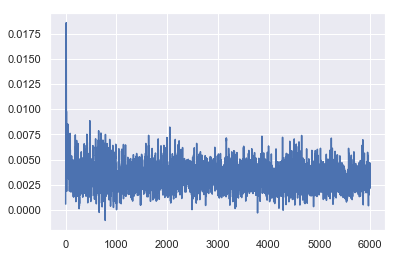

In [367]:
plt.plot(gen_losses)
plt.show()

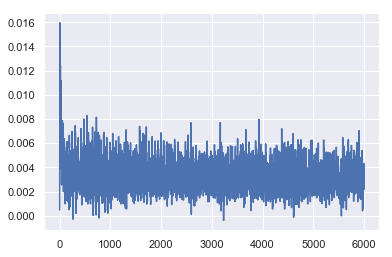

In [368]:
plt.plot(disc_losses)
plt.show()

In [369]:
# to test without train
netD_neg_test = NetD(train_100k.shape[1]).cuda()
netG_neg_test = NetG(train_100k.shape[1]).cuda()

netD_neg_test.eval()
netG_neg_test.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=1690, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1682, bias=True)
    (3): Sigmoid()
  )
)

In [370]:
netD_neg.eval()
netG_neg.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=1690, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1682, bias=True)
    (3): Sigmoid()
  )
)

In [371]:
# checking accuraccy
condition = torch.from_numpy(negative_feedback).float().cuda() 
noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(train_100k > 0).cuda()

concated = torch.cat((noise, condition), 1)
fake_accur_check = netG_neg(e_mask, concated)

In [372]:
# without train
fake_test_accur_check = netG_neg_test(e_mask, concated)

In [373]:
fake_accur_check_ = (fake_accur_check.detach().cpu().numpy() > 0.5).astype(int)

In [374]:
fake_test_accur_check = (fake_test_accur_check.detach().cpu().numpy() > 0.5).astype(int)

In [375]:
(fake_accur_check_ * negative_feedback).sum(), (fake_accur_check_ * positive_feedback).sum()

(25859, 14532)

In [376]:
(fake_test_accur_check * negative_feedback).sum(), (fake_test_accur_check * positive_feedback).sum()

(20002, 25273)

In [377]:
# accuracy on negative items
(fake_accur_check_ * negative_feedback).sum() / negative_feedback.sum()

0.6358405665248715

In [378]:
# accuracy on negative items - WITHOUT TRAIN 
(fake_test_accur_check * negative_feedback).sum() / negative_feedback.sum()

0.49182423959281024

In [379]:
# accuracy on positive items
((1-fake_accur_check_) * positive_feedback).sum() / positive_feedback.sum()

0.7087833911144066

In [380]:
# accuracy on positive items - WITHOUT TRAIN 
((1-fake_test_accur_check) * positive_feedback).sum() / positive_feedback.sum()

0.49353720366325327

In [381]:
# accuracy on positive items - WITHOUT TRAIN 
((1-fake_test_accur_check) * positive_feedback).sum() / positive_feedback.sum()

0.49353720366325327

In [382]:
import gc
gc.collect()

5690

In [365]:
torch.save(netD_neg.state_dict(), './netD_neg-100k')
torch.save(netG_neg.state_dict(), './netG_neg-100k')

In [352]:
del fake_accur_check
del fake_test_accur_check 
del e_mask

In [389]:
# condition, X, idxs = batch_generator(y_neg, to_add_negative, batch_size=256)
# predicting on ngetavie feedbacks
condition = torch.from_numpy(negative_feedback).float().cuda()
# X = torch.from_numpy(to_add_negative).cuda()


noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(train_100k == 0).cuda()

concated = torch.cat((noise, condition), 1)
fake = netG_neg(e_mask, concated)

In [390]:
fake = (fake > 0.8).cpu().numpy()

In [391]:
fake.sum()

525

In [392]:
to_augment_negative = fake

In [393]:
p_probs = [(train_100k == 1).sum()/((train_100k > 0) & (train_100k < 4)).sum(), (train_100k == 2).sum()/(((train_100k > 0) & (train_100k < 4))).sum(), (train_100k == 3).sum()/((train_100k > 0) & (train_100k < 4)).sum()]
p_probs

[0.13777078364356143, 0.2542968846049817, 0.6079323317514569]

In [394]:
augmented_train_100k = train_100k + to_augment_negative

In [395]:
get_sparsity(train_100k), get_sparsity(augmented_train_100k)

(5.710139043178159, 5.743238557340337)

In [239]:
# MF_SGD = ExplicitMF(train_100k, 40, learning='sgd', verbose=True)
# MF_SGD.calculate_learning_curve([300], test_100k, learning_rate=0.001)

In [249]:
MF_SGD = ExplicitMF(augmented_train_100k, 40, learning='sgd', verbose=True)
MF_SGD.calculate_learning_curve([300], test_100k, learning_rate=0.001)

Iteration: 300
	current iteration: 10
	current iteration: 20


KeyboardInterrupt: 

In [247]:
MF_SGD = ExplicitMF(train_100k, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.142822581632546
Test mse: 1.179626365384201
Iteration: 2
Train mse: 1.0730309645422471
Test mse: 1.1283647354414428
Iteration: 5
Train mse: 0.976704786728581
Test mse: 1.0498895036356708
Iteration: 10
Train mse: 0.9191190735106731
Test mse: 0.99882388507181
Iteration: 25
	current iteration: 10
Train mse: 0.8670975465312848
Test mse: 0.9525039875303193
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8395297477072872
Test mse: 0.9342662870213886
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.7572607163519403
Test mse: 0.917558302954112
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.40646564364302945
Test mse: 0.9047525011076776


In [246]:
MF_SGD = ExplicitMF(augmented_train_100k, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.1583192976603522
Test mse: 1.1778921160446154
Iteration: 2
Train mse: 1.0827823219708648
Test mse: 1.124826924658217
Iteration: 5
Train mse: 0.9809962544391533
Test mse: 1.0456674228179015
Iteration: 10
Train mse: 0.9217915122656181
Test mse: 0.9960992361685521
Iteration: 25
	current iteration: 10
Train mse: 0.8695835693024129
Test mse: 0.9521000726072203
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8421152097706776
Test mse: 0.9345373660525688
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.755397379978269
Test mse: 0.916590796822304
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.40575111332308983
Test mse: 0.906762464167835


In [245]:
MF_ALS = ExplicitMF(augmented_train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.365331085064962
Test mse: 10.594736049344187
Iteration: 2
Train mse: 5.692327274625398
Test mse: 8.63601159502765
Iteration: 5
Train mse: 5.390926482500714
Test mse: 8.223490099578223
Iteration: 10
Train mse: 5.382053601809805
Test mse: 8.224694402460047
Iteration: 25
	current iteration: 10
Train mse: 5.365488278184999
Test mse: 8.201579412685142
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.3600334033203785
Test mse: 8.193471712808986
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.35983226130889
Test mse: 8.193220337124336


In [243]:
MF_ALS = ExplicitMF(train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.414043254856359
Test mse: 10.597071517103002
Iteration: 2
Train mse: 5.729849556962303
Test mse: 8.637501957776392
Iteration: 5
Train mse: 5.425216634306679
Test mse: 8.224449939246286
Iteration: 10
Train mse: 5.416034494374579
Test mse: 8.225911144030166
Iteration: 25
	current iteration: 10
Train mse: 5.405244808568524
Test mse: 8.212123871641975
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.394015977369497
Test mse: 8.19475571062152
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.3937671853374605
Test mse: 8.19442505144314


In [250]:
# until test error starts to rise
MF_ALS = ExplicitMF(augmented_train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.365331085064962
Test mse: 10.594736049344187
Iteration: 2
Train mse: 5.692327274625398
Test mse: 8.63601159502765
Iteration: 5
Train mse: 5.390926482500714
Test mse: 8.223490099578223
Iteration: 10
Train mse: 5.382053601809805
Test mse: 8.224694402460047
Iteration: 25
	current iteration: 10
Train mse: 5.365488278184999
Test mse: 8.201579412685142
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.3600334033203785
Test mse: 8.193471712808986
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.35983226130889
Test mse: 8.193220337124336
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 5.35978032575701
Test mse: 8.193157746225948
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 5.359732338000212
Test mse: 8.193099816595986
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse: 5.359687859300

In [251]:
# until test error starts to rise
MF_ALS = ExplicitMF(train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.414043254856359
Test mse: 10.597071517103002
Iteration: 2
Train mse: 5.729849556962303
Test mse: 8.637501957776392
Iteration: 5
Train mse: 5.425216634306679
Test mse: 8.224449939246286
Iteration: 10
Train mse: 5.416034494374579
Test mse: 8.225911144030166
Iteration: 25
	current iteration: 10
Train mse: 5.405244808568524
Test mse: 8.212123871641975
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.394015977369497
Test mse: 8.19475571062152
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.3937671853374605
Test mse: 8.19442505144314
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 5.393714646752196
Test mse: 8.194362304310943
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 5.393666122560651
Test mse: 8.194304259396569
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse: 5.39362115513

In [253]:
# until test error starts to rise

best_sgd_model = ExplicitMF(train_100k, n_factors=80, learning='sgd', \
                            item_fact_reg=0.01, user_fact_reg=0.01, \
                            user_bias_reg=0.01, item_bias_reg=0.01)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200, 220]
best_sgd_model.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.1583192976603522
Test mse: 1.1778921160446154
Iteration: 2
Train mse: 1.0827823219708648
Test mse: 1.124826924658217
Iteration: 5
Train mse: 0.9809962544391533
Test mse: 1.0456674228179015
Iteration: 10
Train mse: 0.9217915122656181
Test mse: 0.9960992361685521
Iteration: 25
	current iteration: 10
Train mse: 0.8695835693024129
Test mse: 0.9521000726072203
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8421152097706776
Test mse: 0.9345373660525688
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.755397379978269
Test mse: 0.916590796822304
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 0.6846501387489577
Test mse: 0.9047955049119271
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 0.6088625770108296
Test mse: 0.8969742625646109
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse

In [372]:
# until convergence
best_sgd_model = ExplicitMF(augmented_train_100k, n_factors=80, learning='sgd', \
                            item_fact_reg=0.01, user_fact_reg=0.01, \
                            user_bias_reg=0.01, item_bias_reg=0.01, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200, 220]
best_sgd_model.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.1545119024961061
Test mse: 1.178567399719999
Iteration: 2
Train mse: 1.0808310124661051
Test mse: 1.1261795339578151
Iteration: 5
Train mse: 0.9808797891168647
Test mse: 1.0474046524170364
Iteration: 10
Train mse: 0.9222637203091965
Test mse: 0.997286882756945
Iteration: 25
	current iteration: 10
Train mse: 0.8708585227221491
Test mse: 0.9523215310455245
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8464129951238863
Test mse: 0.9346230958725521
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.7999830140159173
Test mse: 0.9226304802126559
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 0.7510374101643228
Test mse: 0.9117502158632841
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 0.6909018150472902
Test mse: 0.9010086763640088
Iteration: 160
	current iteration: 10
	current iteration: 20
Train ms

In [257]:
# until convergence
best_sgd_model = ExplicitMF(augmented_train_100k, n_factors=80, learning='sgd', \
                            item_fact_reg=0.01, user_fact_reg=0.01, \
                            user_bias_reg=0.01, item_bias_reg=0.01, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200, 220]
best_sgd_model.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.158486007439644
Test mse: 1.1779978613000384
Iteration: 2
Train mse: 1.083171581612149
Test mse: 1.125028404345431
Iteration: 5
Train mse: 0.9817048627613273
Test mse: 1.0459868491969369
Iteration: 10
Train mse: 0.9227319825521801
Test mse: 0.9963652377560377
Iteration: 25
	current iteration: 10
Train mse: 0.8713373835757132
Test mse: 0.9521701303030687
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.846936197066563
Test mse: 0.934619043527751
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.8000609230973601
Test mse: 0.9225265969757358
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 0.7503523923902362
Test mse: 0.9115515826764651
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 0.689505366026202
Test mse: 0.9008884227444379
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse: 0

In [258]:
# until convergence
best_sgd_model = ExplicitMF(train_100k, n_factors=80, learning='sgd', \
                            item_fact_reg=0.01, user_fact_reg=0.01, \
                            user_bias_reg=0.01, item_bias_reg=0.01, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200, 220]
best_sgd_model.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.142972933039822
Test mse: 1.17972828223402
Iteration: 2
Train mse: 1.0733920132206576
Test mse: 1.1285610630076768
Iteration: 5
Train mse: 0.9773881833559704
Test mse: 1.0502187304294268
Iteration: 10
Train mse: 0.9200456767969902
Test mse: 0.999134022874239
Iteration: 25
	current iteration: 10
Train mse: 0.8688346580213652
Test mse: 0.9526617108778075
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8442347461991091
Test mse: 0.934442842680263
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.7999403795934972
Test mse: 0.9232297270102171
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 0.7525020754101615
Test mse: 0.9130561640976463
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 0.6925429566514093
Test mse: 0.902326297805037
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse: 0

In [259]:
best_als_model = ExplicitMF(train_100k, n_factors=10, learning='als', \
                            item_fact_reg=0.1, user_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200, 220]
best_als_model.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 7.414043254856359
Test mse: 10.597071517103002
Iteration: 2
Train mse: 5.729849556962303
Test mse: 8.637501957776392
Iteration: 5
Train mse: 5.425216634306679
Test mse: 8.224449939246286
Iteration: 10
Train mse: 5.416034494374579
Test mse: 8.225911144030166
Iteration: 25
	current iteration: 10
Train mse: 5.405244808568524
Test mse: 8.212123871641975
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.394015977369497
Test mse: 8.19475571062152
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.3937671853374605
Test mse: 8.19442505144314
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 5.393714646752196
Test mse: 8.194362304310943
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 5.393666122560651
Test mse: 8.194304259396569
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse: 5.39362115513

In [260]:
best_als_model = ExplicitMF(augmented_train_100k, n_factors=10, learning='als', \
                            item_fact_reg=0.1, user_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200, 220]
best_als_model.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 7.365331085064962
Test mse: 10.594736049344187
Iteration: 2
Train mse: 5.692327274625398
Test mse: 8.63601159502765
Iteration: 5
Train mse: 5.390926482500714
Test mse: 8.223490099578223
Iteration: 10
Train mse: 5.382053601809805
Test mse: 8.224694402460047
Iteration: 25
	current iteration: 10
Train mse: 5.365488278184999
Test mse: 8.201579412685142
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.3600334033203785
Test mse: 8.193471712808986
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.35983226130889
Test mse: 8.193220337124336
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 5.35978032575701
Test mse: 8.193157746225948
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 5.359732338000212
Test mse: 8.193099816595986
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse: 5.359687859300

In [183]:
from sklearn.decomposition import NMF
# from sklearn.decomposition import ProjectedGradientNMF
from sklearn.decomposition import SparsePCA
# model = NMF(n_components=10, max_iter=400, alpha=0.1, init='nndsvdar', random_state=seed)
# W = model.fit_transform(train_100k)
# H = model.components_

In [376]:
W.shape, H.shape

((943, 10), (10, 1682))

In [377]:
get_mse(test_100k, np.matmul(W,H))

0.4260560791980288

In [418]:
# model = NMF(n_components=20, max_iter=800, init='nndsvdar', beta_loss='frobenius', alpha=0.1, random_state=seed)
model = NMF(n_components=10, max_iter=5000, alpha=0.1, init='nndsvdar', random_state=seed)
W = model.fit_transform(augmented_train_100k)
H = model.components_

In [419]:
get_mse(test_100k, np.matmul(W,H))

0.42284283620274604

In [420]:
# model = NMF(n_components=20, max_iter=800, init='nndsvdar', beta_loss='frobenius', alpha=0.1, random_state=seed)
model = NMF(n_components=10, max_iter=5000, alpha=0.1, init='nndsvdar', random_state=seed)
W = model.fit_transform(train_100k)
H = model.components_

In [421]:
get_mse(test_100k, np.matmul(W,H))

0.4229995439123597

In [360]:
model = SparsePCA(n_components=10, max_iter=40, alpha=0.1,  random_state=seed)
W = model.fit_transform(augmented_train_100k)
H = model.components_

C:\Users\David\Anaconda3\lib\site-packages\sklearn\decomposition\sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


KeyboardInterrupt: 

In [385]:
get_mse(test_100k, np.matmul(W,H))

0.38982933425042454

In [386]:
model = SparsePCA(n_components=10, max_iter=40, alpha=0.1,  random_state=seed)
W = model.fit_transform(train_100k)
H = model.components_

C:\Users\David\Anaconda3\lib\site-packages\sklearn\decomposition\sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


In [387]:
get_mse(test_100k, np.matmul(W,H))

0.38935982618491954